# **Laboratorio 3**

Edwin Ortega - 22305 Esteban Zambrano - 22119 Juan Pablo Solis - 22102



### **Ejercicio 3**

Centros generados (fijos):
 [[2.99632095 7.60571445]
 [5.85595153 4.78926787]
 [1.24814912 1.24795616]
 [0.4646689  6.92940917]
 [4.80892009 5.66458062]
 [0.16467595 7.75927882]
 [6.65954113 1.69871289]
 [1.45459974 1.46723608]]


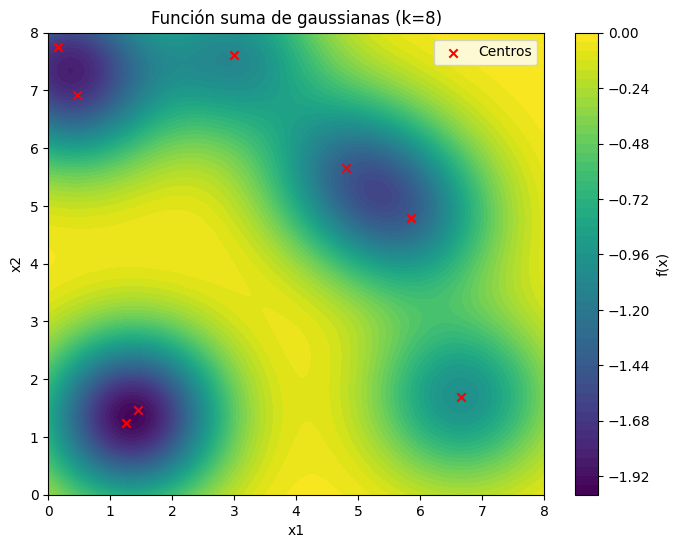

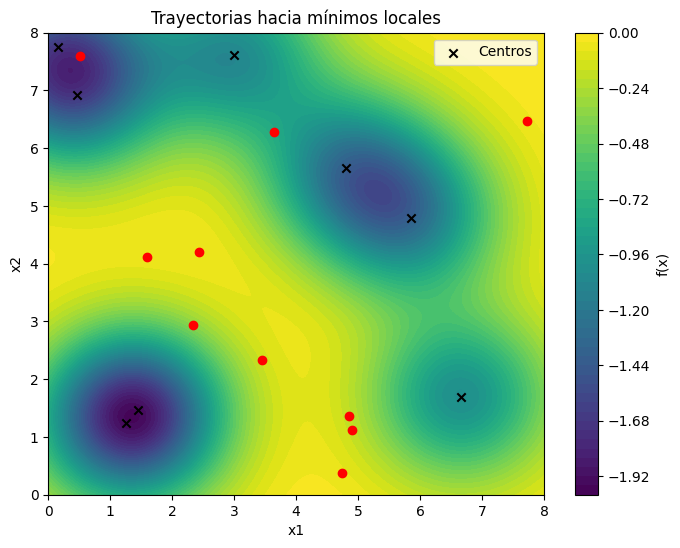


Mínimos locales encontrados:


,x1,x2,f(x)
0,2.433938,4.198051,-0.050149
1,3.455560,2.329833,-0.150937
2,4.894823,1.115951,-0.182418
3,2.337157,2.930895,-0.367807
4,3.648560,6.281408,-0.792668
5,1.597390,4.113876,-0.058443
6,4.739317,0.371603,-0.069656
7,4.860359,1.364193,-0.193700
8,0.520413,7.591084,-1.774313
9,7.725056,6.467179,-0.052991


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

k = 8                
sigma = 1.0          
np.random.seed(42)   
centros = np.random.uniform(0, 8, (k, 2))
print("Centros generados (fijos):\n", centros)

def f(x):
    """Función suma de gaussianas negativas"""
    x = np.array(x)
    return -np.sum(np.exp(-(1/(2*sigma)) * np.sum((x - centros)**2, axis=1)))

def grad_f(x):
    """Gradiente de f(x)"""
    x = np.array(x)
    dif = x - centros
    exp_terms = np.exp(-(1/(2*sigma)) * np.sum(dif**2, axis=1))
    grad = np.sum((dif / sigma) * exp_terms[:, None], axis=0)
    return grad * (-1)

X = np.linspace(0, 8, 200)
Y = np.linspace(0, 8, 200)
XX, YY = np.meshgrid(X, Y)
Z = np.array([[f([xx, yy]) for xx, yy in zip(row_x, row_y)] for row_x, row_y in zip(XX, YY)])

plt.figure(figsize=(8,6))
plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
plt.colorbar(label="f(x)")
plt.scatter(centros[:,0], centros[:,1], c="red", marker="x", label="Centros")
plt.title("Función suma de gaussianas (k=8)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

iniciales = np.random.uniform(0, 8, (10, 2))  
minimos = []

plt.figure(figsize=(8,6))
plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
plt.colorbar(label="f(x)")

for x0 in iniciales:
    res = minimize(f, x0, method="BFGS", jac=grad_f, options={"disp": False})
    minimos.append(res.x)
    
    plt.plot([x0[0], res.x[0]], [x0[1], res.x[1]], "w--", lw=1)
    plt.scatter(res.x[0], res.x[1], c="red", marker="o")

plt.scatter(centros[:,0], centros[:,1], c="black", marker="x", label="Centros")
plt.title("Trayectorias hacia mínimos locales")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

df_minimos = pd.DataFrame(minimos, columns=["x1", "x2"])
df_minimos["f(x)"] = [f(m) for m in minimos]
print("\nMínimos locales encontrados:")
display(df_minimos)


### **Ejercicio 4**

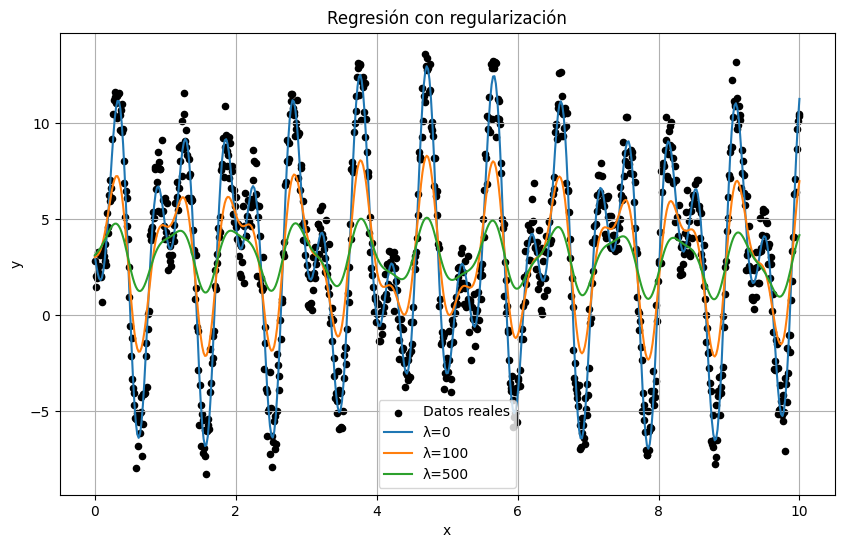


λ = 0, coeficientes β = [ 3.04870793e+00  1.46992338e-02 -3.46345308e-03  5.25038670e+00
 -4.66626183e+00]

λ = 100, coeficientes β = [ 3.00509168  0.05825492 -0.00927662  3.50050107 -1.72072679]

λ = 500, coeficientes β = [ 3.11807245  0.03613293 -0.00938222  1.50186973 -0.48634378]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

data = pd.read_csv("datos_lab3.csv")
x = data["x"].values
y = data["y"].values
n = len(x)


def modelo(beta, x):
    """Modelo: y = b0 + b1*x + b2*x^2 + b3*sin(7x) + b4*sin(13x)"""
    b0, b1, b2, b3, b4 = beta
    return b0 + b1*x + b2*(x**2) + b3*np.sin(7*x) + b4*np.sin(13*x)


def error_regularizado(beta, lam, x, y):
    
    pred = modelo(beta, x)
    error_datos = np.sum((pred - y)**2)
    
    
    diff = np.diff(pred)
    error_reg = np.sum(diff**2)
    
    return error_datos + lam*error_reg


lambdas = [0, 100, 500]
resultados = {}

for lam in lambdas:
    res = minimize(error_regularizado, x0=np.zeros(5), args=(lam, x, y))
    resultados[lam] = res.x  


plt.figure(figsize=(10,6))
plt.scatter(x, y, color="black", s=20, label="Datos reales")

x_plot = np.linspace(min(x), max(x), 500)

for lam in lambdas:
    beta_opt = resultados[lam]
    y_pred = modelo(beta_opt, x_plot)
    plt.plot(x_plot, y_pred, label=f"λ={lam}")

plt.title("Regresión con regularización")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


for lam, beta_opt in resultados.items():
    print(f"\nλ = {lam}, coeficientes β = {beta_opt}")
